#### Import required libraries

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import json
import hourglass 
import preprocessor
import utils

#### Visualize charts and annotations

In [2]:
# File paths to load JSON files
train_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/processed/train_annotations_processed.json'
val_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/processed/val_annotations_processed.json'

# Load processed annotations files
with open(train_file) as f:
        train_annotations = json.load(f)
with open(val_file) as f:
        val_annotations = json.load(f)

In [3]:
train_images = train_annotations['images']
train_annotations = train_annotations['annotations']
val_images = val_annotations['images']
val_annotations = val_annotations['annotations']

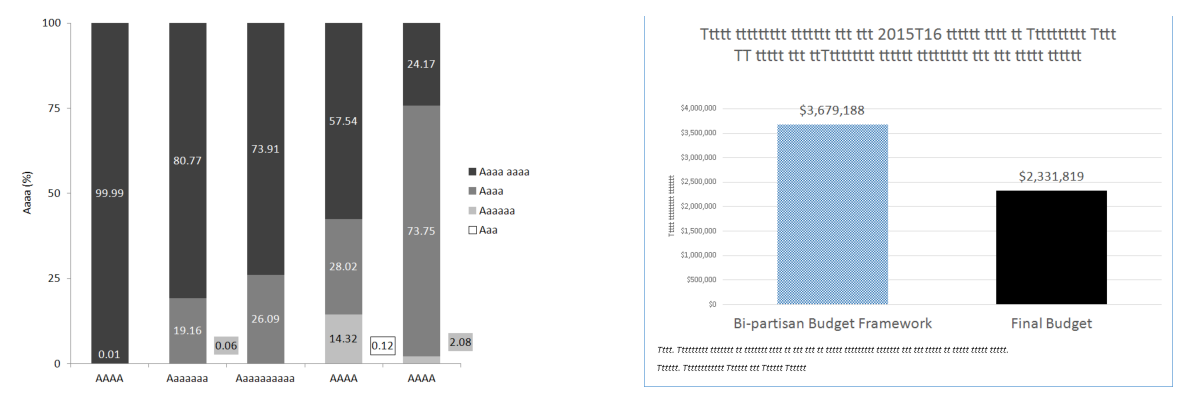

In [4]:
# Display images and annotations from training and validation data
TRAIN_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/train2019'
VAL_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/val2019'

index = 0
file_name = train_images[index]['file_name']
train_path = os.path.join(TRAIN_PATH_BAR, file_name)
train_image = cv2.cvtColor(cv2.imread(train_path), cv2.COLOR_BGR2RGB)
index_ = 750
file_name = val_images[index_]['file_name']
val_path = os.path.join(VAL_PATH_BAR, file_name)
val_image = cv2.cvtColor(cv2.imread(val_path), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image)
axs[1].imshow(val_image)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

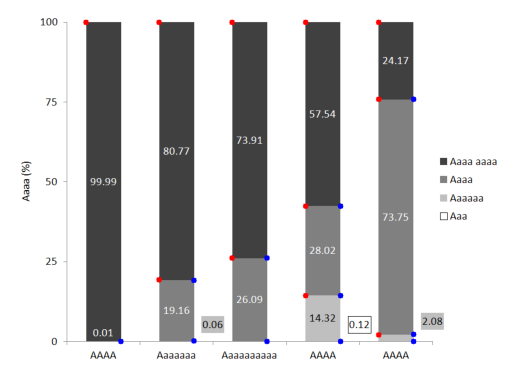

In [5]:
annotation = list(map(lambda x: x['bbox'], train_annotations[index]))
utils.annotshow(train_image, annotation)

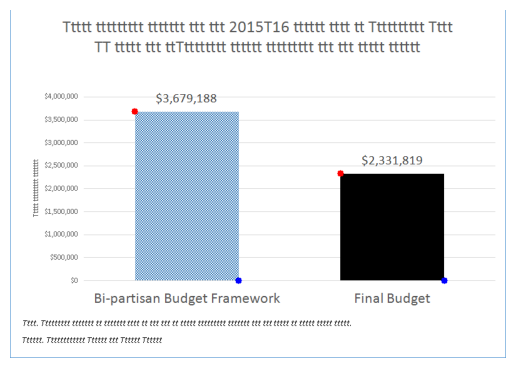

In [6]:
annotation_ = list(map(lambda x: x['bbox'], val_annotations[index_]))
utils.annotshow(val_image, annotation_)

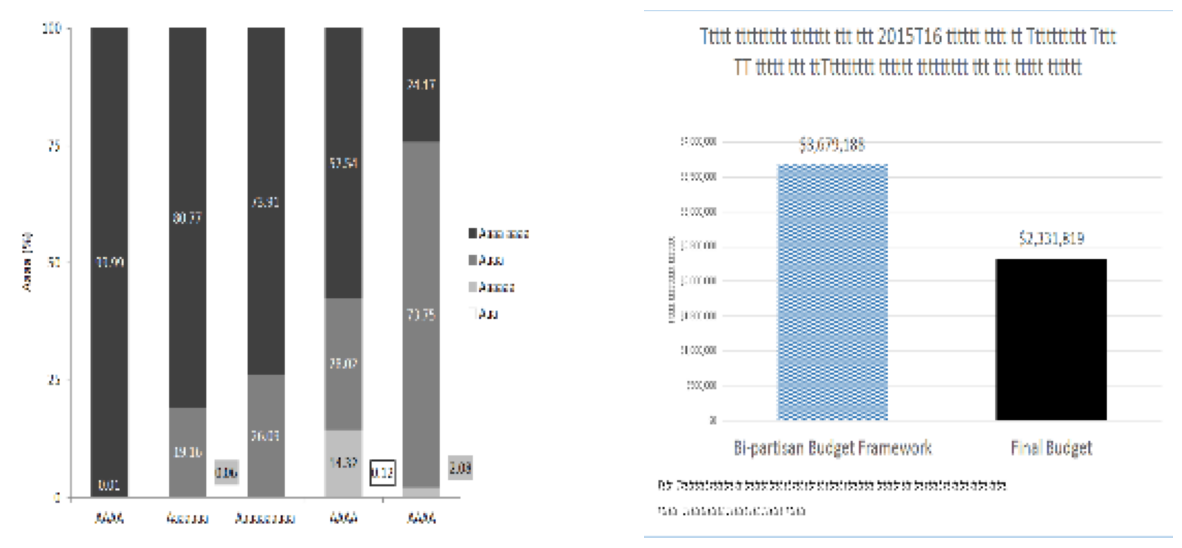

In [7]:
# Display resized images and scaled annotations
train_image_resized = cv2.resize(train_image, (256, 256))
val_image_resized = cv2.resize(val_image, (256, 256))
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image_resized)
axs[1].imshow(val_image_resized)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

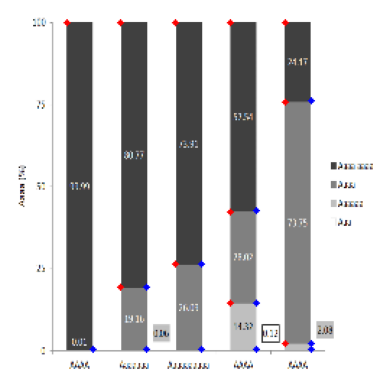

In [8]:
train_image_shape = (train_images[index]['width'], train_images[index]['height'])
OUTPUT_SHAPE = (256, 256)
scaled_train_annotation = preprocessor.scale(train_annotations[index], train_image_shape, OUTPUT_SHAPE)
utils.annotshow(train_image_resized, list(map(lambda x: x['bbox'], scaled_train_annotation)), radius=2)

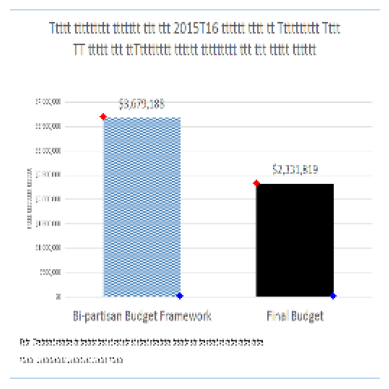

In [9]:
val_image_shape = (val_images[index_]['width'], val_images[index_]['height'])
scaled_val_annotation = preprocessor.scale(val_annotations[index_], val_image_shape, OUTPUT_SHAPE)
utils.annotshow(val_image_resized, list(map(lambda x: x['bbox'], scaled_val_annotation)), radius=2)

#### Preprocessing

In [10]:
TRAIN_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/train'
BATCH_SIZE = 8

In [11]:
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
gen = preprocessor.data_generator(train_images, train_heatmaps, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE, file_path=TRAIN_PATH_BAR)

#### Preprocessing Validation Data

In [12]:
VAL_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/val'

In [13]:
val_heatmaps = sorted(glob(pathname='*.npz', root_dir=VAL_HEATMAPS_PATH))
val_heatmaps = [os.path.join(VAL_HEATMAPS_PATH, item) for item in val_heatmaps]
val_gen = preprocessor.data_generator(val_images, val_heatmaps, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE, file_path=VAL_PATH_BAR)

#### Training

In [14]:
''' 
We define the loss functions as the summation of probability map loss and the smooth L1 loss for keypoint coordinates.
TensorFlow's Huber Loss is essentially equivalent to the smooth L1 loss. The Huber loss is a smooth approximation to the L1 loss (absolute difference) 
that becomes quadratic when the error is small. When δ=1, the Huber loss becomes equivalent to the smooth L1 loss.
'''

from keras.losses import BinaryCrossentropy, Huber

@tf.keras.utils.register_keras_serializable()
def keypoint_loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    huber = Huber(delta=1.0)
    return bce(y_true, y_pred) + huber(y_true, y_pred)

In [15]:
num_samples = len(train_images)
steps_per_epoch = num_samples // BATCH_SIZE
print(f'steps_per_epoch: {steps_per_epoch}')

steps_per_epoch: 19758


In [16]:
num_val_samples = len(val_images)
validation_steps = num_val_samples // BATCH_SIZE
print(f'validation_steps: {validation_steps}')

validation_steps: 764


#### Inference

In [17]:
from tensorflow.keras.models import load_model
stacked_hourglass = load_model('SavedModels/key-point-detector-epoch-1.keras')

In [18]:
paths = [os.path.join(TRAIN_PATH_BAR, image['file_name']) for image in train_images[100000:100016]]
X = np.array([cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), OUTPUT_SHAPE) for path in paths])

In [19]:
predictions = stacked_hourglass.predict(X)

I0000 00:00:1720357584.361921   11766 service.cc:145] XLA service 0x600002f78800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720357584.362199   11766 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-07 18:36:24.418245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720357585.225264   11766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


In [20]:
predictions.shape

(16, 256, 256, 2)

In [21]:
predictions[index].shape

(256, 256, 2)

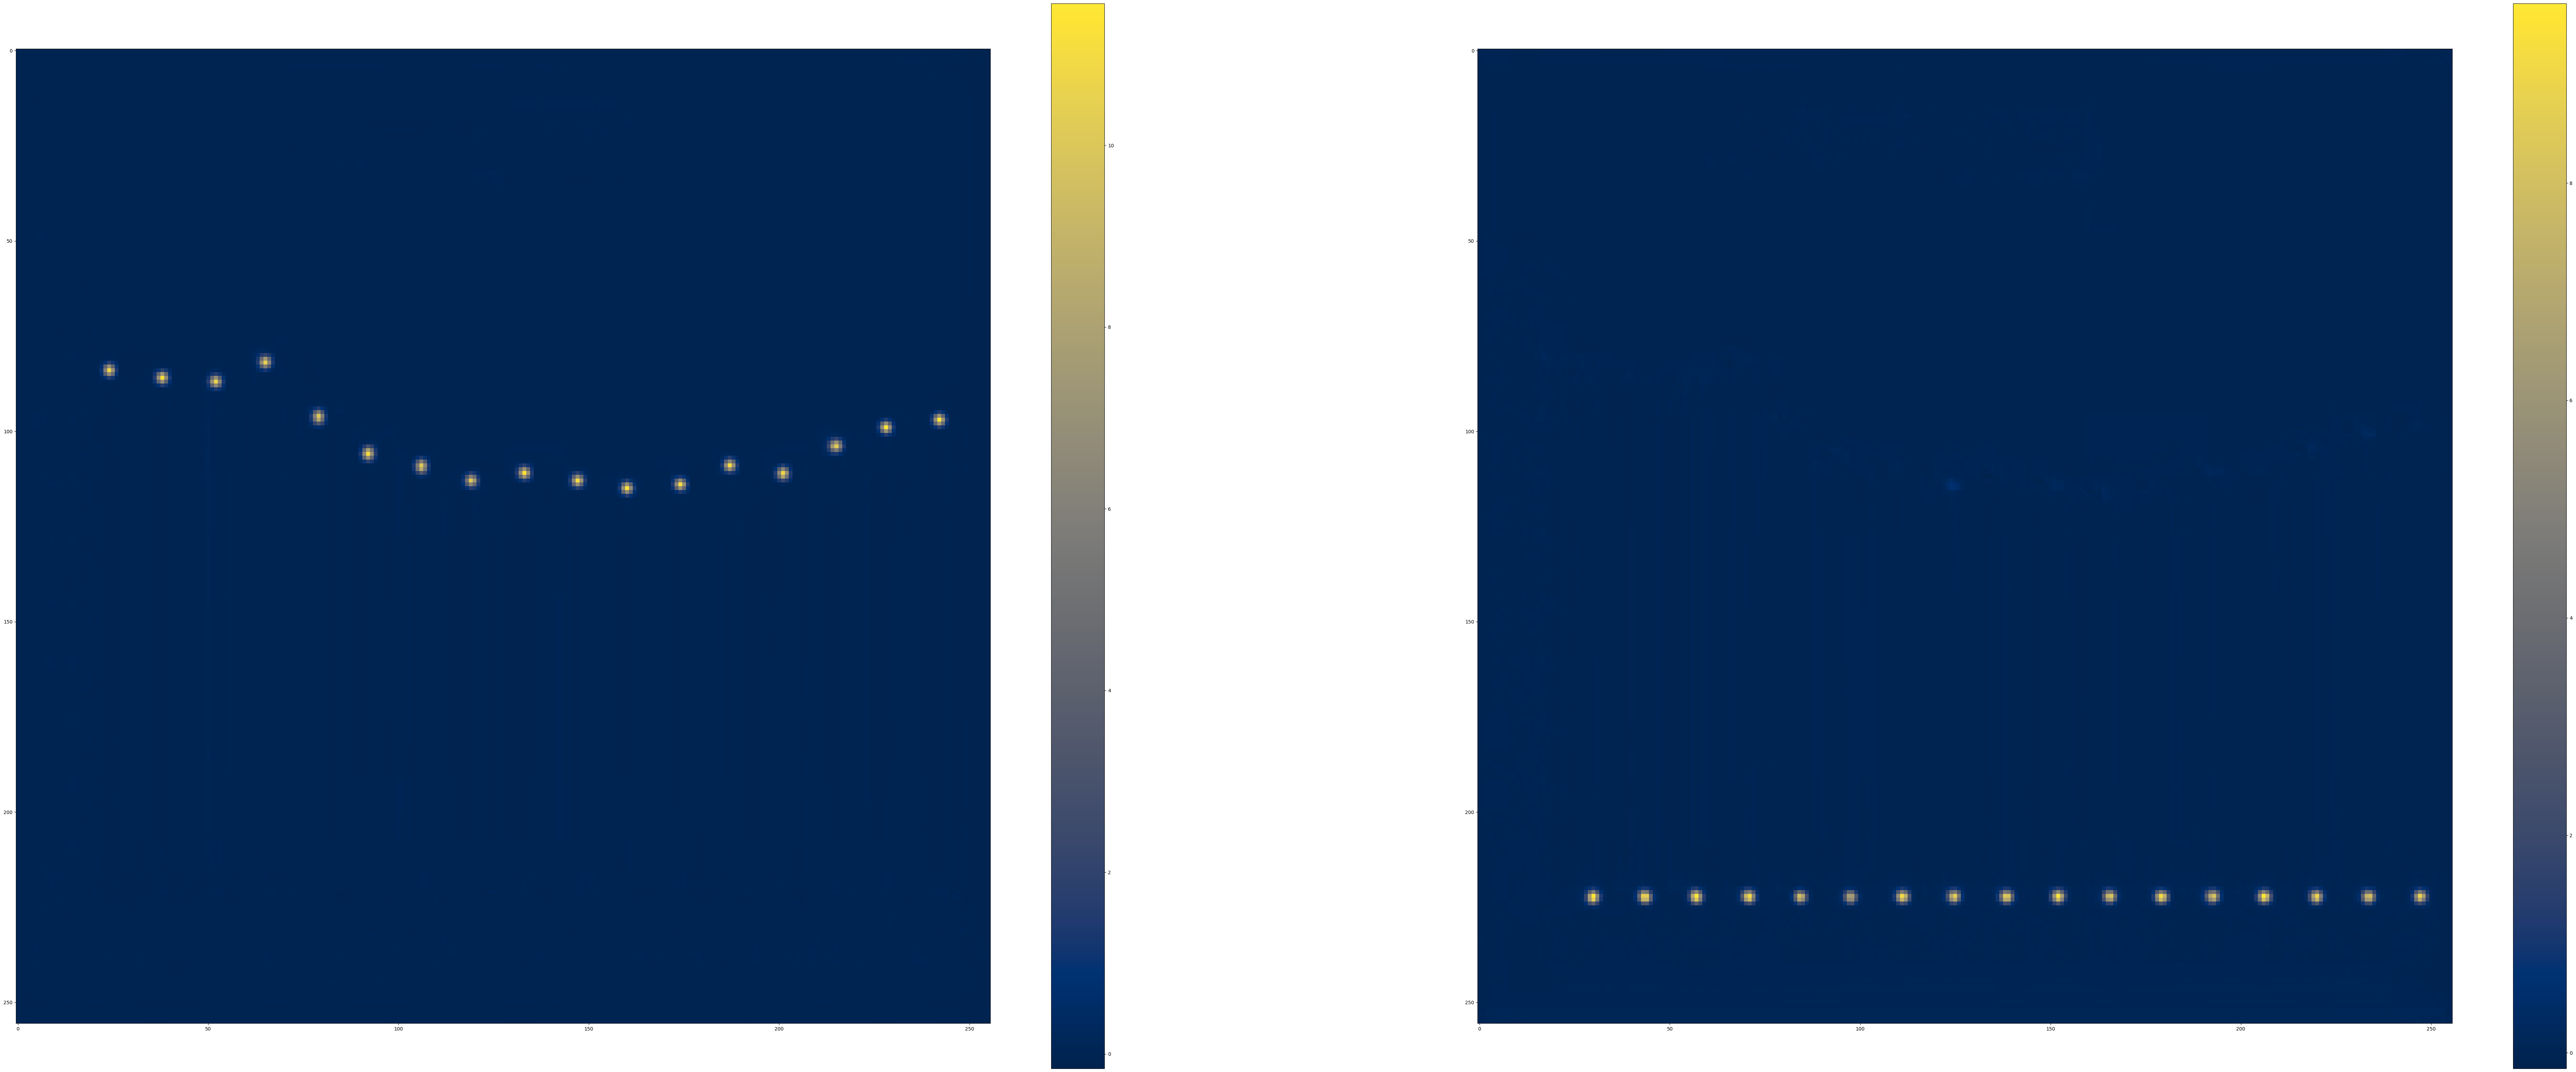

In [22]:
index = 15
predicted_heatmap = predictions[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

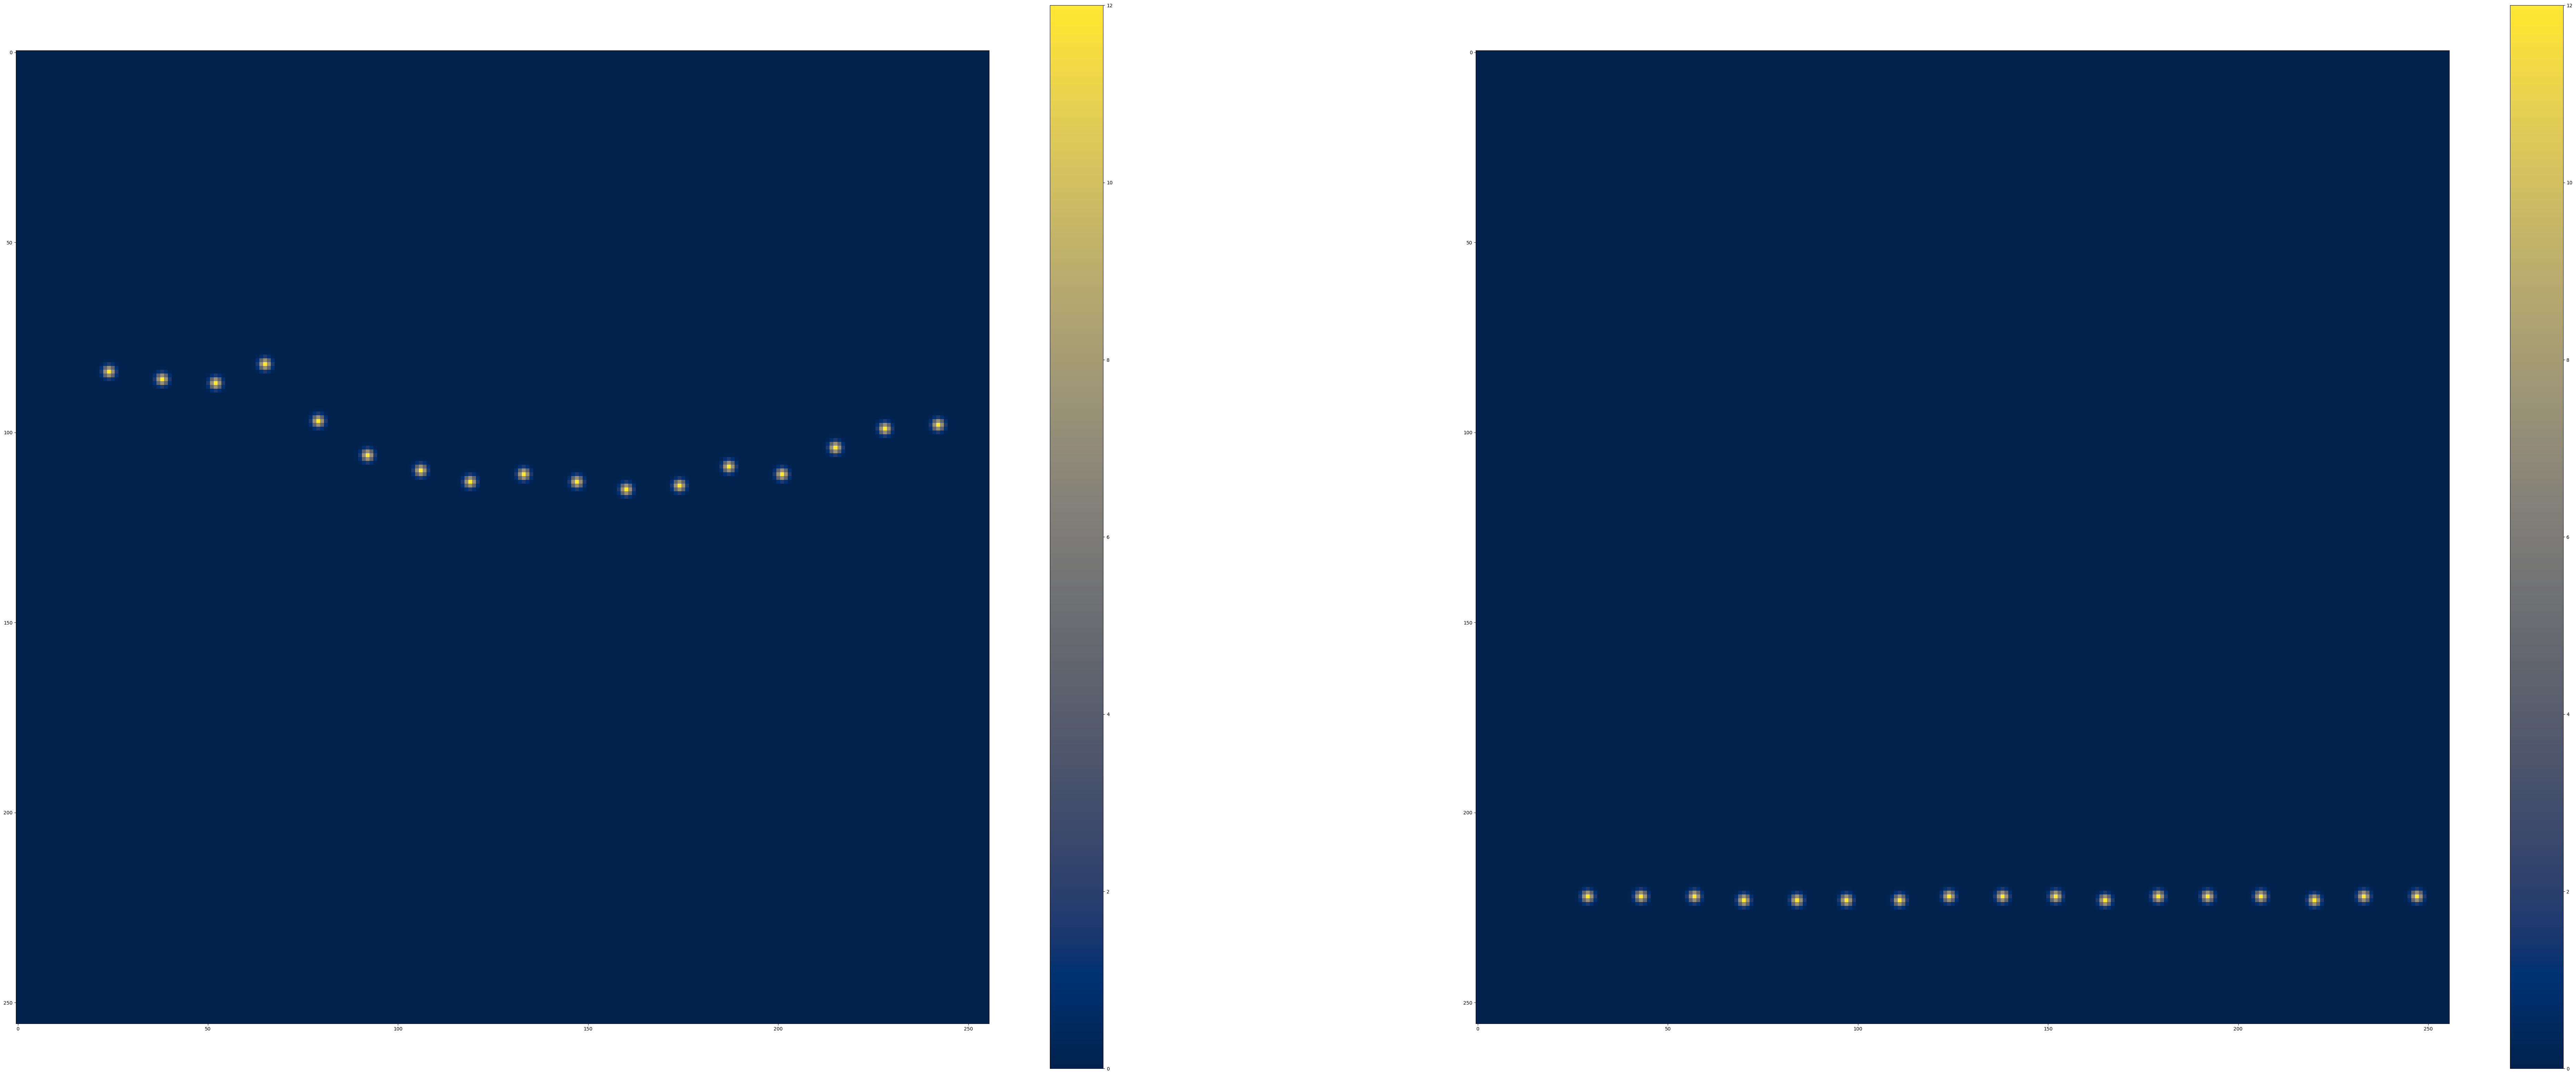

In [23]:
# load two batches of train heatmaps
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))[12500:12502]
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
train_heatmaps = np.concatenate([np.load(heatmap)['batch'] for heatmap in train_heatmaps], axis=0)
heatmap = train_heatmaps[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

In [27]:
from scipy.ndimage import center_of_mass

THRESHOLD = 4

def extract_centroids(predicted_heatmap, threshold):
    retval, dst = cv2.threshold(src=predicted_heatmap, thresh=threshold, maxval=1, type=cv2.THRESH_BINARY)
    centroids_for_both_channels = []
    for i in range(2):
        heatmap = dst[:,:,i].astype(np.uint8)
        # Find contours (islands)
        contours, _ = cv2.findContours(heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Calculate the centroid for each contour
        centroids = []
        for contour in contours:
            # Calculate the centroid using moments
            M = cv2.moments(contour)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                centroids.append((cx, cy))
        centroids_for_both_channels.append(centroids)
    return centroids_for_both_channels

In [45]:
def match_bar_coordinates(centroids):
    top_left, bottom_right = centroids
    matched_coordinates = list(zip(sorted(top_left), sorted(bottom_right)))
    return matched_coordinates

In [50]:
centroids = extract_centroids(predicted_heatmap,threshold=THRESHOLD)
matched_coordinates = match_bar_coordinates(centroids)
matched_coordinates

[((24, 84), (30, 222)),
 ((38, 86), (43, 222)),
 ((52, 87), (56, 222)),
 ((65, 81), (70, 222)),
 ((79, 96), (84, 222)),
 ((92, 106), (97, 222)),
 ((106, 109), (111, 222)),
 ((119, 113), (124, 222)),
 ((133, 111), (138, 222)),
 ((147, 113), (152, 222)),
 ((160, 115), (165, 222)),
 ((174, 114), (179, 222)),
 ((187, 109), (192, 222)),
 ((201, 111), (206, 222)),
 ((214, 103), (220, 222)),
 ((227, 99), (233, 222)),
 ((242, 97), (247, 222))]

In [36]:
centroids

[[(160, 115),
  (174, 114),
  (147, 113),
  (119, 113),
  (201, 111),
  (133, 111),
  (187, 109),
  (106, 109),
  (92, 106),
  (214, 103),
  (227, 99),
  (242, 97),
  (79, 96),
  (52, 87),
  (38, 86),
  (24, 84),
  (65, 81)],
 [(97, 222),
  (84, 222),
  (247, 222),
  (233, 222),
  (220, 222),
  (206, 222),
  (192, 222),
  (179, 222),
  (165, 222),
  (152, 222),
  (138, 222),
  (124, 222),
  (111, 222),
  (70, 222),
  (56, 222),
  (43, 222),
  (30, 222)]]

In [53]:
width = train_images[100000:100016][index]['width']
height = train_images[100000:100016][index]['height']

In [55]:
height

395

In [56]:
width

902

In [57]:
train_images[100000:100016][index]

{'file_name': 'a098df3edd09f210f39c4cda31ffe404_d3d3LnNhdWRlLnNjLmdvdi5icgkyMDAuMTkuMjIyLjg=.xls-2-0.png',
 'height': 395,
 'width': 902,
 'id': 100059}